# Dependencies

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import loadmat
from MP import progress_bar
from glob import glob
import pandas as pd
import time,os
from matplotlib import gridspec
gs=gridspec.GridSpec
uet=progress_bar.update_elapsed_time

from MP.lib import mpl_lib
from MP.lib.mpl_lib import rm_all_lab as ral
from MP.lib.mpl_lib import tune_xy_lim as txl
from matplotlib.colors import LogNorm

from MP.mat import mech

- Current work direction 

In [3]:
pwd

u'/Users/yj/repo/FLD_DIC_XRAY/tutorials/DIC_analysis/IF_steel/PSRD'

- Available files

In [4]:
date='20141112'
dic_path=os.path.join('/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/',date,'DIC')
# print dic_path
print os.popen('ls %s/*.mat'%dic_path).read()

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0000_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0001_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0002_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0003_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0004_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0005_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0006_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0007_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0008_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/IFsteel_PSRD-0009_0.mat
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/201

- Pick a file name ( each file corresponds to single snapshot)

In [5]:
fn_start='%s/*0???_0.mat'%dic_path
fns=glob(fn_start)
for fn in fns:
    # print fn
    if not(os.path.isfile(fn)):
        raise IOError, '%s is not loadable'%fn

- Load the file and measure the file loading time

In [6]:
t0=time.time()
dat_raw=[]
dic_ind=[]
for i in xrange(len(fns)):
    fn =fns[i]
    dum=os.path.split(fn)[-1].split('.mat')[0][::-1]
    dum = dum[:6][::-1]
    ind=int(dum[:4:])
    # print fn,ind
    dic_ind.append(ind)
    dat_dict=loadmat(fn)
    dat_raw.append(dat_dict)
    if mod(i,10)==0: uet(time.time()-t0,head='loading time:')

loading time:: 654 [ ms]

In [7]:
# print dic_ind

- Variables available in each file

In [10]:
# print dat_raw[0].keys()

In [11]:
nstp = len(dat_raw)
nx,ny = dat_raw[-1]['sigma'].shape
print 'Total number of steps (# of DIC snapshots):', nstp
print '2D resolution (nx,ny):', nx,ny,'nx*ny:',nx*ny

Total number of steps (# of DIC snapshots): 22
2D resolution (nx,ny): 255 333 nx*ny: 84915


# Comparison between unfiltered raw data and data filtered by $\sigma$ 

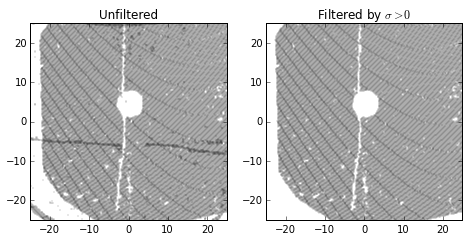

In [12]:
fig=plt.figure(121,figsize=(8,4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.scatter(dat_raw[-1]['X'],dat_raw[-1]['Y'],marker='.',s=0.05)
ax1.set_xlim(-25,25);ax1.set_ylim(-25,25)
ax1.set_aspect('equal');ax1.set_title('Unfiltered')

ax2.scatter(dat_raw[-1]['X'][dat_raw[-1]['sigma']>0],dat_raw[-1]['Y'][dat_raw[-1]['sigma']>0],marker='.',s=0.05)
ax2.set_xlim(-25,25);ax2.set_ylim(-25,25)
ax2.set_aspect('equal');ax2.set_title(r'Filtered by $\sigma>0$')

# Define necessary functions

In [13]:
"""
Find minimum or maximum discarding +- inp and nan
"""
def find_mx(a):
    mx=None
    for i in xrange(len(a)):
        if ((a[i]>mx and a[i]!=np.inf) or mx==None) and not(np.isnan(a[i])): 
            mx=a[i]
    return mx

def find_mxi(a):
    mx=None; ind=None
    for i in xrange(len(a)):
        if ((a[i]>mx and a[i]!=np.inf) or mx==None) and not(np.isnan(a[i])): 
            mx=a[i]
            ind=i
    return mx,ind

def find_mn(a):
    mn=None
    for i in xrange(len(a)):
        if ((a[i]<mn and a[i]!=-np.inf) or mn==None) and not(np.isnan(a[i])): mn=a[i]
    return mn

def find_mni(a):
    mn=None; ind=None
    for i in xrange(len(a)):
        if ((a[i]<mn and a[i]!=np.inf) or mn==None) and not(np.isnan(a[i])): 
            mn=a[i]
            ind=i
    return mn,ind

def find_mxmn(*args):
    """
    Return max and min
    """
    maxs, mns=[], []
    for a in args:
        mns.append(find_mn(a))
        mxs.append(find_mx(a))
    return mxs, mns

## Contruct a normalized spectrum of color
def make_cb(dat,mn=None,mx=None,log=False):
    """
    Arguments
    =========
    dat
    mn  = None
    mx  = None
    log = False (If True, use LogNorm)
    """
    array = dat.flatten()
    if mn==None: mn = find_mn(array) 
    if mx==None: mx = find_mx(array)
    if log: norm=LogNorm(vmin=mn,vmax=mx)
    else:   norm=mpl.colors.Normalize(vmin=mn,vmax=mx)
    cmap,m = mpl_lib.norm_cmap(mn=mn,mx=mx,cm_name='jet')
    return cmap, norm, m

- Data masking bases on $\sigma$ values - those elements with $\sigma>0.$

In [14]:
#np.maskdat_raw[0]['q_ref']
t0=time.time()
iplot=False

for istp in xrange(nstp):
    dum=dat_raw[istp]['sigma'][dat_raw[istp]['sigma']>0]
    if iplot: plot(dum.flatten(),'x')
    if iplot: uet(time.time()-t0,head='plotting time:')
uet(time.time()-t0,head='Total time elapsed')

Total time elapsed:   7 [ ms]

- Test dat_mask can easily mask unwanted data based on its 'key' from the dictionary raw data "dat_raw" array.

key:"exx" 
-----------


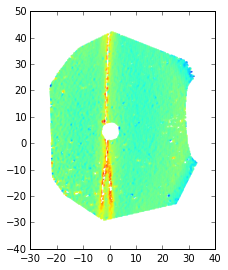

In [15]:
## Data masking
def dat_mask(dat_raw,istp,*keys):
    """
    From dat_raw, mask the data
    that have its corresponding 'sigma' value 
    lower than zero.
    
    Also, return masked data for the given step.
    """
    d=[]
    k=0
    for key in keys:
        # if k==0:print np.array(dat_raw[istp][key]).shape
        if key=='evm':
            array = calc_EVM(dat_raw[istp])
        elif key=='dEzz_dt':
            array = calc_dEzz_dt(dat_raw[istp])
        elif key=='ezz':
            array = calc_ezz(dat_raw[istp])
        else:
            array = dat_raw[istp][key]
        sigma = dat_raw[istp]['sigma']
        array = array[sigma>0]
        d.append(array)        
        k=k+1
    return d


def calc_EVM(dat_raw):
    """
    Calculate EVM
    """
    e1 = dat_raw['e1']
    e2 = dat_raw['e2']
    e3 = -e1-e2 #0.
    
    evm = 2./3. * (e1**2+e2**2+e3**2)
    evm = np.sqrt(evm)
    return evm

def calc_ezz(dat_raw):
    exx = dat_raw['exx']
    eyy = dat_raw['eyy']
    return -exx-eyy

def calc_dEzz_dt(dat_raw):
    dExx_dt = dat_raw['dExx_dt']
    dEyy_dt = dat_raw['dEyy_dt']
    return -dExx_dt - dEyy_dt



## --
key='exx'
#key='dExx_dt'
#key='e3'
print 'key:"%s"'%key,'\n-----------'
for istp in xrange(nstp):
    x, y, z = dat_mask(dat_raw,istp,'X','Y',key)
    mx, mn  = find_mx(z), find_mn(z)
    #if istp==0: print '%5s %5s'%('min','max')
    #print '%5.3f %5.3f'%(mn, mx)

cmap, norm, m = make_cb(z,mn=mn,mx=mx)
C=m.to_rgba(z)
scatter(x,y,color=C,marker='.',s=0.3)
plt.gca().set_aspect('equal')

# PLOT XY(Z)

nx 57131


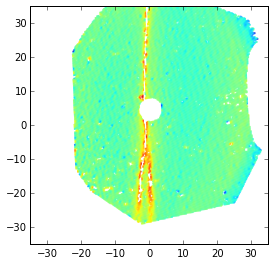

In [16]:
istp=-1
keys = 'evm'
X,Y,Z = dat_mask(dat_raw, istp, 'X','Y',key)  ## premasked array by 'sigma'
mn,mx=find_mn(Z),find_mx(Z)
cmap,norm,m = make_cb(dat=Z,mn=mn,mx=mx)

nx,= X.shape
print 'nx',nx
cs=[];X_=[];Y_=[];

c = m.to_rgba(Z)
plt.scatter(X,Y,marker='.',color=c,s=0.5)#,s=0.05)
plt.gca().set_xlim(-35,35); plt.gca().set_ylim(-35,35)
plt.gca().set_aspect('equal')

In [19]:
"""
Keys in the dictionary file:
----------------------------
'q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt',
'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy'
"""
t0=time.time()
key = 'e_vonmises'

nc=int(sqrt(nstp))+1
nr=nstp/nc; nr = nr + 1
print nc,nr

if nc*nr<nstp: raise IOError, 'Insufficient cells'
g=gs(nc*10,(nr+1)*10,hspace=0,wspace=0)

ux=2;uy=2

## Switch for plotting
### ---------------------------------------------------------------
iplot=False
### ---------------------------------------------------------------
if iplot: fig=plt.figure(figsize=((nr+1)*ux,nc*uy))

mns=[];mxs=[]
for istp in xrange(nstp):
    Z, = dat_mask(dat_raw,istp,key)
    mn, mx = find_mn(Z),find_mx(Z)
    mns.append(mn); mxs.append(mx)
    uet(time.time()-t0,head='Elapsed time for finding max and min:')
mn,mx = find_mn(mns), find_mx(mxs)
print
print 'minimum and maximum',mn, mx

if iplot:
    norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
    cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)


k = 0; axes = []
t0=time.time()
for i in xrange(nc):
    for j in xrange(nr):
        if iplot:
            ax=fig.add_subplot(g[i*10:(i+1)*10,j*10:(j+1)*10])
            ax.set_aspect('equal')
            ax.minorticks_on()
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='both', which='minor', labelsize=8)

        x,y,z=dat_mask(dat_raw,k,'X','Y',key)
        if iplot:
            cs=m.to_rgba(z)
            ax.scatter(x,y,marker='.',color=cs,s=0.02)
            ax.set_xlim(-35,35);ax.set_ylim(-35,35)
            ax.locator_params(nbins=4)
            ax.text(x=0.8,y=0.9,s='# %i'%k,verticalalignment='center',
                    horizontalalignment='center',
                    fontsize=12,transform=ax.transAxes)
        k=k+1
        if i==nc-1 and j==0:
            if iplot:
                ax.set_xlabel('X [mm]',dict(fontsize=15))
                ax.set_ylabel('Y [mm]',dict(fontsize=15))
        else: 
            if iplot:
                axes.append(ax)
        if iplot: uet(time.time()-t0,head='Elapsed time for plotting:')
        else: uet(time.time()-t0,head='Elapsed time for data masking')
        if k>=nstp: break
    if k>=nstp: break

if iplot:
    txl(fig.axes)        
    ral(axes)

    axcb=fig.add_subplot(g[(nc-1)*10:(nc)*10,(nr)*10+1:(nr)*10+2])
    mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
                   format='%5.3f',norm=norm,
                   ylab=r'%s '%key)

uet(time.time()-t0,head='Elapsed time:')

5 5
Elapsed time for finding max and min::   1 [sec]
minimum and maximum 1.2389e-18 0.902991
Elapsed time::  43 [ ms]

## -- As a first approximation, get an average with an small area

- Reduce data set by area

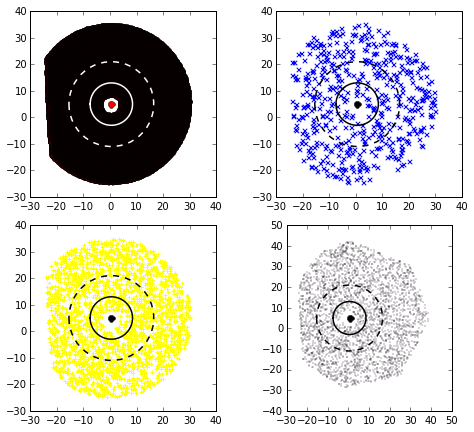

In [23]:
def r_area(x,y,rad,x0,y0,*args):
    """
    Reduce the data by its radius
    """
    x,y = x-x0,y-y0
    r = np.sqrt(x**2+y**2)
    zs=[]
    for arg in args:
        zs.append(arg[r<rad])
    return zs

def rr(x,y,rad,x0,y0,p,*args):
    #print len(x) ,' ->',
    zs=r_area(x,y,rad,x0,y0,*args)
    #print len(zs[0]), '->',
    
    if p<0: return zs
    elif p>0 and p<1: 
        #print len(zs[0])
        n = int(len(zs[0])*p)
        #print n
    elif p==1:
        return zs

    slc = random.choice(len(zs[0]),n)
    Z=[]
    for i in range(len(zs)):
        Z.append(zs[i][slc])
    return Z

def stat(dat):
    return np.average(dat), np.std(dat)


## application
key = 'e_vonmises'
x_,y_,z_=dat_mask(dat_raw,0,'X','Y',key)

## masking by 'area' and extract from only a portion of total data
fig=plt.figure(figsize=(7,9))
ax1=fig.add_subplot(323)
ax2=fig.add_subplot(324)
ax3=fig.add_subplot(325)
ax4=fig.add_subplot(326)

## for PSRD
x0=0.5; y0=5.;
rad_washer=16.
rad=8.

x,y,z = rr(x_,y_,30,x0,y0,1,x_,y_,z_)
ax1.scatter(x,y,marker='.',c='red')
x,y,z = rr(x_,y_,30,x0,y0,0.01,x_,y_,z_)
ax2.scatter(x,y,marker='x',c='blue')
x,y,z = rr(x_,y_,30,x0,y0,0.05,x_,y_,z_)
ax3.scatter(x,y,marker='+',c='yellow')
x,y,z = rr(x_,y_,40,x0,y0,0.05,x_,y_,z_)
ax4.scatter(x,y,marker='o',c='magenta',s=0.04)

## Trace of window of the washer
thw=np.linspace(-pi,pi)
xw=np.cos(thw)*rad_washer+x0
yw=np.sin(thw)*rad_washer+y0
xa=np.cos(thw)*rad+x0
ya=np.sin(thw)*rad+y0

ax1.plot(x0,y0,'ro')
ax1.plot(xw,yw,'w--')
ax1.plot(xa,ya,'w-')

for ax in fig.axes[1:]:
    ax.plot(x0,y0,'ko')
    ax.plot(xw,yw,'k--')
    ax.plot(xa,ya,'k-')
for ax in fig.axes:
    ax.set_aspect('equal')
plt.tight_layout()

In [24]:
path=os.path.split(fn_start)[0]
fn=os.path.join(path,'DIC_results.txt')
print fn
f=open(fn,'w')

keys=['e1','e2','exx','eyy','exy','sigma']
evm = []
for istp in xrange(nstp):
    if istp==0:
        f.write('%4s '%'DIC')
        for key in keys:
            f.write('%5s_A %5s_E '%(key,key))
        f.write('\n')
    f.write('%4.4i '%dic_ind[istp])
    for key in keys:
        x, y, z= dat_mask(dat_raw,istp,'X','Y',key)
        #   rr(x,y,rad,x0,y0,p,*args):
        zr = rr(x,y,rad,x0,y0,-1,z)
        avg,std= stat(zr)
        f.write('%7.4f %7.4f '%(avg, std))
    f.write('\n')
f.close()
st=os.popen('cat %s'%fn).read()
print st

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC/DIC_results.txt
 DIC    e1_A    e1_E    e2_A    e2_E   exx_A   exx_E   eyy_A   eyy_E   exy_A   exy_E sigma_A sigma_E 
0000  0.0019  0.0022 -0.0019  0.0022 -0.0001  0.0029  0.0001  0.0015  0.0000  0.0017  0.0263  0.0078 
0001  0.0025  0.0031 -0.0020  0.0031  0.0001  0.0037  0.0004  0.0021  0.0001  0.0024  0.0267  0.0078 
0002  0.0025  0.0029 -0.0020  0.0027  0.0001  0.0036  0.0004  0.0022  0.0001  0.0021  0.0268  0.0077 
0003 -0.0000  0.0000 -0.0000  0.0000 -0.0000  0.0000 -0.0000  0.0000 -0.0000  0.0000  0.0328  0.0097 
0004  0.0028  0.0035 -0.0028  0.0047 -0.0004  0.0051  0.0004  0.0029  0.0002  0.0027  0.0325  0.0084 
0005  0.0025  0.0032 -0.0032  0.0052 -0.0006  0.0055 -0.0002  0.0025  0.0004  0.0029  0.0238  0.0076 
0006  0.0027  0.0036 -0.0033  0.0059 -0.0006  0.0061 -0.0001  0.0027  0.0004  0.0032  0.0232  0.0075 
0007  0.0029  0.0041 -0.0032  0.0051 -0.0004  0.0053  0.0000  0.0033  0.0004  0.0033  0.0229  0.00

# Below is added for individual color-map. Be cautious as they might be very slow... 

- Color map for individual DIC images

5 5
minimum and maximum -0.861562 0.222318
Elapsed time:: 16.50 [sec]
/Users/yj/repo/FLD_DIC_XRAY/tutorials/test_local_DIC.png has been saved.


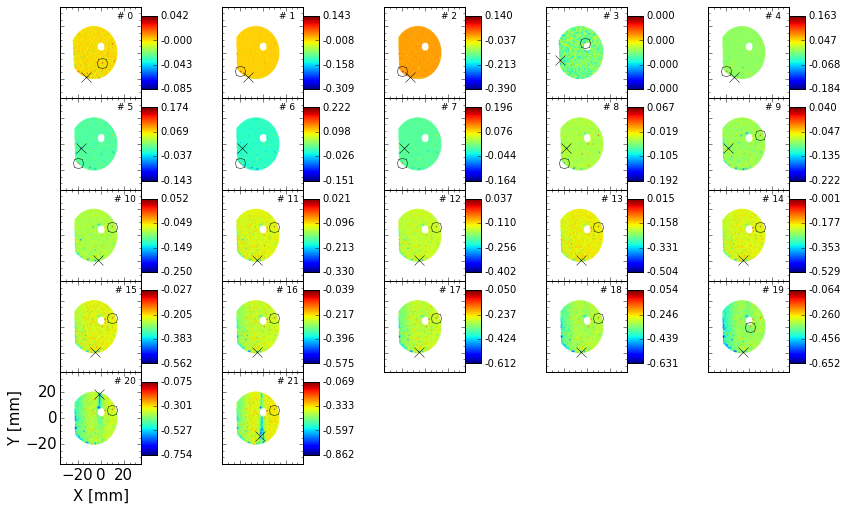

In [20]:
"""
Keys in the dictionary file:
----------------------------
'q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt',
'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy'
"""
t0=time.time()
# key = 'e1'
# key = 'dEzz_dt'
key = 'ezz'
s=0.05

nc=int(sqrt(nstp))+1
nr=nstp/nc; nr = nr + 1
print nc,nr

if nc*nr<nstp: raise IOError, 'Insufficient cells'
g=gs(nc*13,(nr+1)*10,hspace=0,wspace=0)

ux=2;uy=2
fig=plt.figure(figsize=((nr+4)*ux,nc*uy))


## Use data within a certain range of distance (rad) from x0,y0
rad= 20.
x0 =-6.
y0 = 0.


mns=[];mxs=[];mxi=[];mni=[]
for istp in xrange(nstp):
    x,y,z = dat_mask(dat_raw,istp,'X','Y',key)
    x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
    mn= find_mn(z)
    mx,ix = find_mxi(z)
    mn,im = find_mni(z)
    mns.append(mn); mxs.append(mx);mxi.append(ix);mni.append(im)
mn,mx = find_mn(mns), find_mx(mxs)
print 'minimum and maximum',mn, mx


k = 0; axes = []
for i in xrange(nc):
    for j in xrange(nr):
        mn,mx = mns[k],mxs[k]
        norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
        cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

        ax  =fig.add_subplot(g[i*10    :i*10+10,j*10  :j*10+5])
        axcb=fig.add_subplot(g[i*10+1  :i*10+9,j*10+5:j*10+6])
        #ax.set_aspect('equal')
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=8)

        ## confine data to be plotted
        x,y,z=dat_mask(dat_raw,k,'X','Y',key)
        x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
        
        x_mx, y_mx = x[mxi[k]],y[mxi[k]]
        x_mn, y_mn = x[mni[k]],y[mni[k]]
        
        cs=m.to_rgba(z)
        ax.scatter(x,y,marker='.',color=cs,s=s)
        ax.plot(x_mx,y_mx,'o',mfc='None',mec='k',ms=10)
        ax.plot(x_mn,y_mn,'x',mfc='None',mec='k',ms=10)
        ax.set_xlim(-35,35);ax.set_ylim(-35,35)
        ax.locator_params(nbins=4)
        ax.text(x=0.8,y=0.90,s='# %i'%dic_ind[k],verticalalignment='center',
                horizontalalignment='center',
                fontsize=9,transform=ax.transAxes)
        k=k+1
        if i==nc-1 and j==0:
            ax.set_xlabel('X [mm]',dict(fontsize=15))
            ax.set_ylabel('Y [mm]',dict(fontsize=15))
        else: axes.append(ax)

        cb=mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
               format='%5.3f',norm=norm,
               ylab='')
        cb.set_ticks(np.linspace(mn,mx,4))

        if k>=nstp: break
    if k>=nstp: break

# txl(fig.axes)
ral(axes)

uet(time.time()-t0,head='Elapsed time:')
print

fn_fig=os.path.join(os.getcwd(),'test_local_DIC.png')
gcf().savefig(fn_fig,bbox_inches='tight')
print fn_fig, 'has been saved.'

5 5
minimum and maximum -0.159971 0.816954
Elapsed time:: 12.66 [sec]
/Users/yj/repo/FLD_DIC_XRAY/tutorials/test_local_DIC.png has been saved.


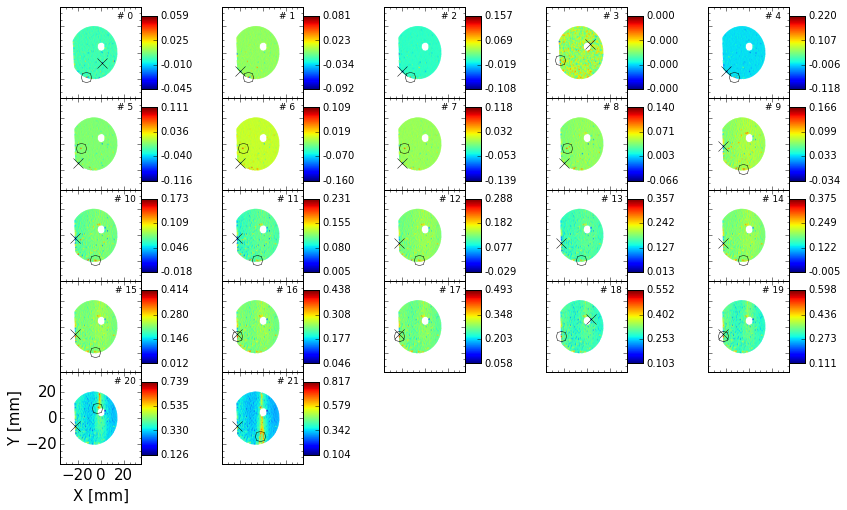

In [22]:
"""
Keys in the dictionary file:
----------------------------
'q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt',
'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy'
"""
t0=time.time()
# key = 'e1'
# key = 'dEzz_dt'
key = 'exx'
s=0.05

nc=int(sqrt(nstp))+1
nr=nstp/nc; nr = nr + 1
print nc,nr

if nc*nr<nstp: raise IOError, 'Insufficient cells'
g=gs(nc*13,(nr+1)*10,hspace=0,wspace=0)

ux=2;uy=2
fig=plt.figure(figsize=((nr+4)*ux,nc*uy))


## Use data within a certain range of distance (rad) from x0,y0
rad= 20.
x0 =-6.
y0 = 0.


mns=[];mxs=[];mxi=[];mni=[]
for istp in xrange(nstp):
    x,y,z = dat_mask(dat_raw,istp,'X','Y',key)
    x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
    mn= find_mn(z)
    mx,ix = find_mxi(z)
    mn,im = find_mni(z)
    mns.append(mn); mxs.append(mx);mxi.append(ix);mni.append(im)
mn,mx = find_mn(mns), find_mx(mxs)
print 'minimum and maximum',mn, mx


k = 0; axes = []
for i in xrange(nc):
    for j in xrange(nr):
        mn,mx = mns[k],mxs[k]
        norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
        cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

        ax  =fig.add_subplot(g[i*10    :i*10+10,j*10  :j*10+5])
        axcb=fig.add_subplot(g[i*10+1  :i*10+9,j*10+5:j*10+6])
        #ax.set_aspect('equal')
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=8)

        ## confine data to be plotted
        x,y,z=dat_mask(dat_raw,k,'X','Y',key)
        x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
        
        x_mx, y_mx = x[mxi[k]],y[mxi[k]]
        x_mn, y_mn = x[mni[k]],y[mni[k]]
        
        cs=m.to_rgba(z)
        ax.scatter(x,y,marker='.',color=cs,s=s)
        ax.plot(x_mx,y_mx,'o',mfc='None',mec='k',ms=10)
        ax.plot(x_mn,y_mn,'x',mfc='None',mec='k',ms=10)
        ax.set_xlim(-35,35);ax.set_ylim(-35,35)
        ax.locator_params(nbins=4)
        ax.text(x=0.8,y=0.90,s='# %i'%dic_ind[k],verticalalignment='center',
                horizontalalignment='center',
                fontsize=9,transform=ax.transAxes)
        k=k+1
        if i==nc-1 and j==0:
            ax.set_xlabel('X [mm]',dict(fontsize=15))
            ax.set_ylabel('Y [mm]',dict(fontsize=15))
        else: axes.append(ax)

        cb=mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
               format='%5.3f',norm=norm,
               ylab='')
        cb.set_ticks(np.linspace(mn,mx,4))

        if k>=nstp: break
    if k>=nstp: break

# txl(fig.axes)
ral(axes)

uet(time.time()-t0,head='Elapsed time:')
print

fn_fig=os.path.join(os.getcwd(),'test_local_DIC.png')
gcf().savefig(fn_fig,bbox_inches='tight')
print fn_fig, 'has been saved.'

5 5
minimum and maximum -0.195099 0.285059
Elapsed time::  9.31 [sec]
/Users/yj/repo/FLD_DIC_XRAY/tutorials/test_local_DIC.png has been saved.


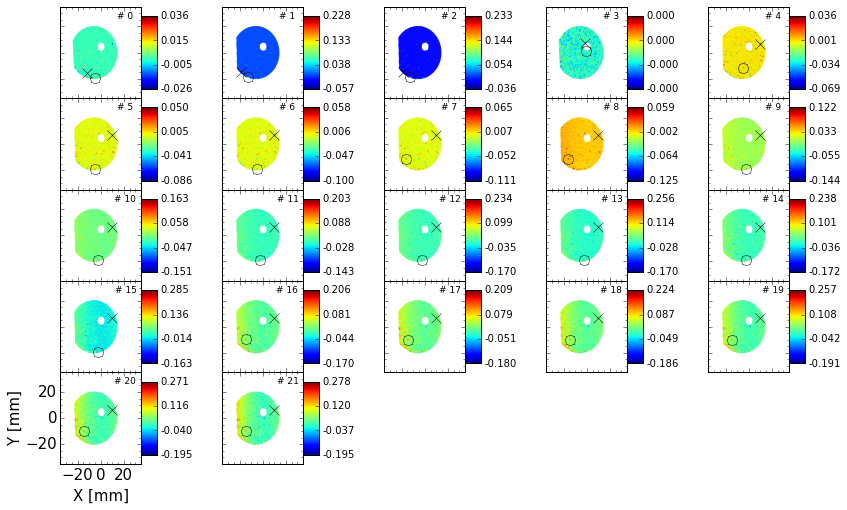

In [23]:
"""
Keys in the dictionary file:
----------------------------
'q_ref', 'dV_dt', 'X', 'dExx_dt', 'dEyy_dt', 'eyy', 'r_ref', 'e_vonmises', 'e3_dot', 'U', 'W', 'V', 'Y', 'dU_dt',
'Z', 'e1', 'e3', 'e2', 'dExy_dt', 'q', 'r', 'u', 'exx', 'v', 'y', 'x', 'dW_dt', 'sigma', 'gamma', 'exy'
"""
t0=time.time()
# key = 'e1'
# key = 'dEzz_dt'
key = 'eyy'
s=0.05

nc=int(sqrt(nstp))+1
nr=nstp/nc; nr = nr + 1
print nc,nr

if nc*nr<nstp: raise IOError, 'Insufficient cells'
g=gs(nc*13,(nr+1)*10,hspace=0,wspace=0)

ux=2;uy=2
fig=plt.figure(figsize=((nr+4)*ux,nc*uy))


## Use data within a certain range of distance (rad) from x0,y0
rad= 20.
x0 =-6.
y0 = 0.


mns=[];mxs=[];mxi=[];mni=[]
for istp in xrange(nstp):
    x,y,z = dat_mask(dat_raw,istp,'X','Y',key)
    x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
    mn= find_mn(z)
    mx,ix = find_mxi(z)
    mn,im = find_mni(z)
    mns.append(mn); mxs.append(mx);mxi.append(ix);mni.append(im)
mn,mx = find_mn(mns), find_mx(mxs)
print 'minimum and maximum',mn, mx


k = 0; axes = []
for i in xrange(nc):
    for j in xrange(nr):
        mn,mx = mns[k],mxs[k]
        norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
        cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

        ax  =fig.add_subplot(g[i*10    :i*10+10,j*10  :j*10+5])
        axcb=fig.add_subplot(g[i*10+1  :i*10+9,j*10+5:j*10+6])
        #ax.set_aspect('equal')
        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=8)

        ## confine data to be plotted
        x,y,z=dat_mask(dat_raw,k,'X','Y',key)
        x,y,z=rr(x,y,rad,x0,y0,1,x,y,z) # reduce the size
        
        x_mx, y_mx = x[mxi[k]],y[mxi[k]]
        x_mn, y_mn = x[mni[k]],y[mni[k]]
        
        cs=m.to_rgba(z)
        ax.scatter(x,y,marker='.',color=cs,s=s)
        ax.plot(x_mx,y_mx,'o',mfc='None',mec='k',ms=10)
        ax.plot(x_mn,y_mn,'x',mfc='None',mec='k',ms=10)
        ax.set_xlim(-35,35);ax.set_ylim(-35,35)
        ax.locator_params(nbins=4)
        ax.text(x=0.8,y=0.90,s='# %i'%dic_ind[k],verticalalignment='center',
                horizontalalignment='center',
                fontsize=9,transform=ax.transAxes)
        k=k+1
        if i==nc-1 and j==0:
            ax.set_xlabel('X [mm]',dict(fontsize=15))
            ax.set_ylabel('Y [mm]',dict(fontsize=15))
        else: axes.append(ax)

        cb=mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
               format='%5.3f',norm=norm,
               ylab='')
        cb.set_ticks(np.linspace(mn,mx,4))

        if k>=nstp: break
    if k>=nstp: break

# txl(fig.axes)
ral(axes)

uet(time.time()-t0,head='Elapsed time:')
print

fn_fig=os.path.join(os.getcwd(),'test_local_DIC.png')
gcf().savefig(fn_fig,bbox_inches='tight')
print fn_fig, 'has been saved.'

In [21]:
## Choose reference image.
print '%3s %3s %5s %5s'%('stp','DIC','MX','MN')
for istp in xrange(nstp):
    print '%3.3i %3.3i %5.5i %5.5i'%(istp,dic_ind[istp], mni[istp],mxi[istp])

stp DIC    MX    MN
000 000 17463 06640
001 001 17454 21744
002 002 17443 21731
003 003 23407 07643
004 004 17419 21699
005 005 20172 21694
006 006 20324 21689
007 007 20317 21682
008 008 20297 21794
009 009 20254 01160
010 010 09010 01270
011 011 11626 01269
012 012 11622 01269
013 013 11620 01269
014 014 11619 01269
015 015 11619 01269
016 016 11618 01269
017 017 11618 01269
018 018 11617 01269
019 019 11614 06424
020 020 07217 01269
021 021 08774 01269


In [23]:
istp_ref=007
dic_id = dic_ind[istp_ref]
mni, mxi= mni[istp_ref], mxi[istp_ref]

xyi = mni # or mxi 
print dic_id, xyi
## 



7 1368


In [24]:
def rho_transform(rho):                                                                                                         
    """                                                                                                                         
    Rho transformation (rho<=1 or rho>1)                                                                                        
    """                                                                                                                         
    if rho<=1.: return rho                                                                                                      
    if rho>1: return -1 *(rho -1.) + 1 

def draw_guide(ax,r_line = [-0.5,0. ,1,2,2.5],max_r=2,                                                                               
               ls='--',color='k',alpha=0.5):                                                                                   
    """                                                                                                                        
    Maximum should be a radius...                                                                                              
    """                                                                                                                        
    # guide lines for probed paths                                                                                             
    xlim=ax.get_xlim(); ylim=ax.get_ylim()                                                                                     
    for i in range(len(r_line)):                                                                                               
        r = r_line[i]                                                                                                          
        if r<=1:                                                                                                               
            mx=max_r                                                                                                           
            mx = mx/np.sqrt(1.+r**2)                                                                                           
            ys = np.linspace(0.,mx)                                                                                            
            xs = r * ys                                                                                                        
        elif r>1:                                                                                                              
            r = rho_transform(r)                                                                                           
            my = mx/np.sqrt(1.+r**2)                                                                                           
            xs = np.linspace(0.,my)                                                                                            
            ys = r * xs                                                                                                        
                                                                                                                               
        ax.plot(xs,ys,ls=ls,color=color,alpha=alpha)                                                                           
                                                                                                                               

    ax.set_xlim(xlim)                                                                                                          
    ax.set_ylim(ylim)                                                                                                          
                      

(-0.5, 0.5)

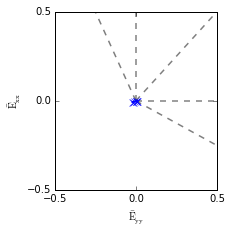

In [25]:
Ex=[]; Ey=[]
for istp in xrange(istp_ref):
    x,y = dat_mask(dat_raw,istp,'exx','eyy')
    x,y = rr(x,y,rad,x0,y0,1,x,y) # reduce the size
    Ex.append(x[xyi])
    Ey.append(y[xyi])
    
fig=plt.figure(figsize=(3,3))    
ax=fig.add_subplot(111)
draw_guide(ax)
ax.plot(Ey,Ex,'x-')
ax.locator_params(nbins=4)
ax.set_ylabel(r'$\mathrm{\bar{E}_{xx}}$')
ax.set_xlabel(r'$\mathrm{\bar{E}_{yy}}$')

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.5,0.5)

